<img src="https://raw.githubusercontent.com/brazil-data-cube/code-gallery/master/img/logo-bdc.png" align="right" width="64"/>

# <span style="color:#336699">BIG Love Data Day - Acesso, visualização e extração de séries temporais de Sentinel-2 utilizando Python</span>
<hr style="border:2px solid #0077b9;">

<br/>

<div style="text-align: center;font-size: 90%;">
    Rennan F. B. Marujo, Gilberto R. Queiroz, Karine R. Ferreira, 
    <br/><br/>
    Divisão de Observação da Terra e Geoinformática, Instituto Nacional de Pesquisas Espaciais (INPE)
    <br/>
    Avenida dos Astronautas, 1758, Jardim da Granja, São José dos Campos, SP 12227-010, Brazil
    <br/><br/>
    Contact: <a href="mailto:brazildatacube@inpe.br">brazildatacube@inpe.br</a>
    <br/><br/>
    Ultíma Atualização: 11 de Abril de 2025
</div>

<br/>

<div style="text-align: justify;  margin-left: 25%; margin-right: 25%;">
<b>Resumo.</b> Este Jupyter Notebook é parte do material do Love Data Day organizado pela <em>Base de Informações Georeferenciadas</em> (BIG) do <em>Instituto Nacional de Pesquisas Espaciais</em> (INPE). Nele é demonstrado como utilizar o serviço SpatioTemporal Asset Catalog (STAC) para descobrir e consultar dados disponíveis no catálogo do instituto, bem como também é demonstrado o uso do serviço Web Time Series Service (WTSS) para extrair séries temporais.
</div>

<img src="https://data.inpe.br/big/web/wp-content/uploads/2024/05/logo-BIG-INPE.svg" align="right" width="64"/>

# BIG
<hr style="border:1px solid #0077b9;">

O Programa Base de Informações Georreferenciadas (BIG) do INPE representa um marco na modernização da infraestrutura de dados geoespaciais do Brasil, oferecendo serviços avançados para acesso, processamento e análise do acervo de imagens de satélite do instituto.
além de ter como base protocolos modernos de compartilhamento de dados, adequados ao uso em ambientes de ciência de dados e computação em nuvem.

Por meio da Base de Informações Georreferenciadas (BIG), o INPE oferece um amplo portfólio de dados geoespaciais, integrando tanto informações processadas internamente, como as imagens dos satélites AMAZONIA e CBERS, fundamentais para o monitoramento ambiental brasileiro, quanto conjuntos de dados estratégicos de parceiros internacionais, destacando-se as imagens da constelação Sentinel, da Agência Espacial Europeia (ESA).

Para mais informações consulte:

<a href="https://data.inpe.br/big/web/">BIG Website</a>

<a href="https://data.inpe.br/stac/browser/?.language=en">INPE STAC Browser</a>

<a href="https://github.com/brazil-data-cube/code-gallery">Repositório Code Gallery no GitHub</a>

Para as atividades de hoje, seguiremos o seguinte fluxograma:

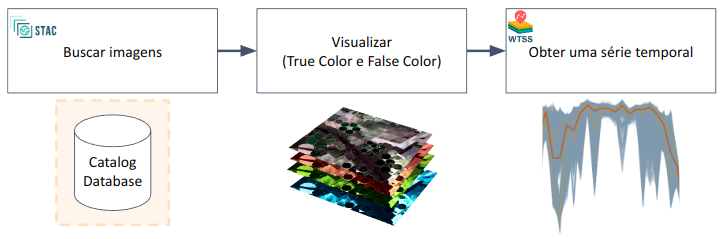

Preparação de versões
<hr style="border:1px solid #0077b9;">

Nesse notebook utilizaremos algumas versões específicas de pacotes.

Para isso você deve instalar os pacotes abaixo utilizando o comando `pip`

Caso você ja tenha executado o comando `import` em algum desses pacotes será necessário clicar na aba `Kernel` do Geolab e `Restart Kernel` para que seja possíovel ser carregada a versão instalada.

In [ ]:
!pip install wtss==2.0.0a3

Para visualizarmos o polígono da gleba sobre um mapa de referência, é possível utilizar as bibliotecas `ipyleaflet` e `ipywidgets`.

In [ ]:
# Área de exibição de camadas (mapa) e mapas base (basemaps)
from ipyleaflet import Map, basemaps, basemap_to_tiles

# Controles sobre o mapa
from ipyleaflet import FullScreenControl, LayersControl, ScaleControl, SplitMapControl, WidgetControl

# Tipos de Camadas
from ipyleaflet import GeoJSON, TileLayer

# Layout
from ipywidgets import IntSlider, Layout

# Abrindo um shapefile e definindo uma area de estudo
<hr style="border:1px solid #0077b9;">

Neste exemplo vamos usar um arquivo `.shp`. Para isso, será usada a biblioteca GeoPandas. Vamos abrir esse arquivo e extrair a informação de geometria.

In [ ]:
import geopandas as gpd

Podemos abrir um .shp diretamente ou um .zip contendo um .shp da seguinte forma:

In [ ]:
# shapefile = "/home/jovyan/data/area.shp"
# my_shp = gpd.read_file(shapefile)
# my_shp.head()

Ou podemos abrir um .shp armazenado online da seguinte forma:

In [ ]:
import io
import os
import requests
import tempfile
import zipfile

zipfile_url = "https://raw.githubusercontent.com/brazil-data-cube/code-gallery/refs/heads/master/jupyter/events/big-techtalks/2025-love-data-day/data/area.zip"
response = requests.get(zipfile_url)
with tempfile.TemporaryDirectory() as tmpdir:
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        z.extractall(tmpdir)

        shp_file = [f for f in os.listdir(tmpdir) if f.endswith('.shp')][0]
        shp_path = os.path.join(tmpdir, shp_file)

        my_shp = gpd.read_file(shp_path)

        geometry_union = my_shp.geometry.unary_union
        bbox = geometry_union.bounds
        centroide = geometry_union.centroid
my_shp

In [ ]:
geometry_union = my_shp.geometry.union_all()
centroide = geometry_union.centroid
bbox = geometry_union.bounds

bbox

Podemos criar uma camada para armazenar as informações desse poligono:

In [ ]:
import shapely

camada_poly = GeoJSON(
    name="Polígono",
    data=shapely.geometry.mapping(geometry_union),
    style={ 'color': 'SteelBlue', 'opacity': 1, 'fillOpacity': 0.1, 'weight': 5 },
    hover_style={ 'color': 'IndianRed', 'opacity': 1, 'fillOpacity': 0.1, 'weight': 5 }
)

Vamos vizualizar onde encontra-se essa área:

In [ ]:
mapa = Map(zoom=10,
           scroll_wheel_zoom=True,
           center=(centroide.y, centroide.x), # [lat, lon]
           layout=Layout(width='80%', height='500px')
           )
mapa.add(camada_poly)
mapa

Podemos inclusive visualizar o bbox dessa area:

# 1. Buscar imagens

---


Vamos começar buscando as imagens que utilizaremos.

Para isso utilizaremos o serviço SpatioTemporal Asset Catalog (STAC) por meio de um client na linguagem de programação Python.

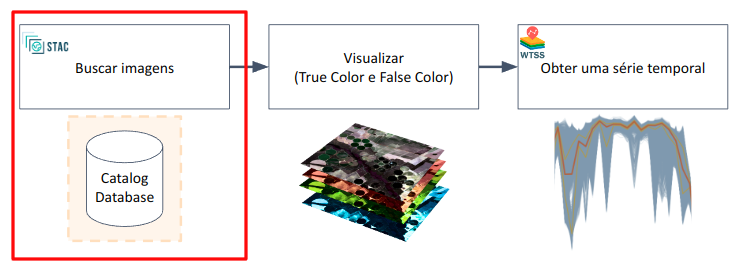

<img src="https://raw.githubusercontent.com/brazil-data-cube/code-gallery/master/img/stac/stac.png?raw=true" align="right" width="66"/>

## Catálogo de Coleções de Imagem de Sensoriamento Remoto: **S**patio**T**emporal **A**sset **C**atalog (STAC)
<hr style="border:1px solid #0077b9;">

Boa parte dos produtos de imagem do [Brazil Data Cube](https://data.inpe.br/bdc/web/) são disponibilizados de maneira aberta na forma de arquivos otimizados para *cloud*, o denominado formato **C**loud **O**ptimized **G**eoTIFF (**COG**). Este formato permite que as aplicações possam utilizar as imagens através da Web com o melhor compromisso possível, incluindo o uso de pirâmide de multi-resolução para aplicações de visualização ou até mesmo a recuperação parcial de porções de uma imagem.


Esses produtos de dados podem ser consultados utilizando uma interface de programação de aplicações baseada no padrão aberto [**S**patio**T**emporal **A**sset **C**atalog (STAC)](https://stacspec.org/). Esta especificação, criada por organizações e especialistas do setor geoespacial, é baseada nos conceitos apresentados no diagrama abaixo:

<center>
<img src="https://raw.githubusercontent.com/brazil-data-cube/code-gallery/master/img/stac/stac-concept.png" width="480" />
<br/>
Modelo de funcionamento do STAC.
</center>

Em que:

- **Catalog**: É um tipo de objeto que fornece uma estrutura para vincular vários itens ou coleções STAC juntos ou mesmo outros catálogos. Na figura acima, o catálogo é composto de três coleções: Landsat/OLI, CBERS4/WFI e Sentinel-2/MSI.

- **Collection:** É uma especialização do catálogo que permite incluir informações adicionais sobre uma determinada coleção espaço-temporal. Uma coleção pode conter informações como o conjunto de bandas espectrais disponíveis das imagens, a extensão geográfica ou área de cobertura das imagens, o período de tempo que compreende a coleção, entre outras informações. Em geral, através da coleção chegamos aos itens dessa coleção.

- **Item**: Corresponde à unidade atômica de metadados, fornecendo *links* para os *assets* associados. Um *Item* é descrito através da notação GeoJSON, como uma feição (*feature*) contendo atributos específicos como a coleção a que ele pertence, propriedades temporais, *links* para os *assets* e coleções ou catálogos associados. Na figura acima, um `Item` equivale a uma cena obtida por um satélite em um determinado instante de tempo.

- **Asset**: Um *asset* é qualquer recurso geoespacial, como um arquivo de imagem ou arquivo vetorial, contendo informações sobre a supefície da Terra, em um determinado espaço e tempo.


A especificação conceitual do STAC permite dois tipos de implementações:

- **STAC estático:** Baseada em um conjunto de documentos JSON ligados que podem ser facilmente navegados. Ex: [CBERS na AWS](https://cbers-stac-1-0-0.s3.amazonaws.com/CBERS4/catalog.json).

- **STAC dinâmico:** Baseada em uma API RESTful, de modo que a navegação é realizada através de uma API de serviço web que permite realizar consultas utilizando uma linguagem padrão para acessar subconjuntos do catálogo. Ex: [BDC-STAC](https://data.inpe.br/bdc/stac/v1).


<br/>
<div style="text-align: justify;  margin-left: 25%; margin-right: 25%;font-size: 75%; border-style: solid; border-color: #0077b9; border-width: 1px; padding: 5px;">
    <b>Nota:</b> Como parte do aperfeiçoamento dos produtos e serviços disponibilizados pelo INPE à sociedade, encontra-se em desenvolvimento o novo portal <a href="https://data.inpe.br/">https://data.inpe.br/</a>, que faz parte da modernização da infraestrutura de serviços para acesso às imagens de satélites do acervo do instituto. Esse portal foi criado com o intuito de facilitar a pesquisa e obtenção das imagens disponibilizadas gratuitamente. Esse novo serviço tem como base as tecnologias desenvolvidas no projeto Brazil Data Cube, e está ancorado dentro do Programa Base de Informações Georreferenciadas (BIG) do INPE. Para navegar pelas coleções disponibilizadas no serviço STAC do INPE, utilize a instância do [STAC Browser](https://data.inpe.br/stac/browser/).
</div>

Cliente STAC no Python
<hr style="border:1px solid #0077b9;">

Para demonstrar o acesso aos produtos de dados do Brazil Data Cube, iremos utilizar uma bibloteca de software livre para Python denominada [PySTAC Client](https://pystac-client.readthedocs.io/en/stable/) (`pystac-client`).

Para instalar essa biblioteca no ambiente Jupyter, pode ser utilizado o comando `pip install`:

In [ ]:
# !pip install pystac-client

Uma vez instalada a biblioteca `pystac-client`, podemos carregar suas funcionalidades através do comando `import`, como mostrado abaixo:

In [ ]:
import pystac_client

Em geral, uma biblioteca do ecossistema Python possui uma constante especial para informar a versão da biblioteca carregada. Abaixo, apresentamos a versão carregada  da biblioteca `pystac-client`:

In [ ]:
pystac_client.__version__

<img src="https://raw.githubusercontent.com/brazil-data-cube/code-gallery/master/img/stac/stac-catalog.png?raw=true" align="right" width="300"/>

## Descobrindo as Coleções em um Catálogo STAC
<hr style="border:1px solid #0077b9;">

O endereço do serviço STAC do BDC é https://data.inpe.br/bdc/stac/v1/. Para descobir as coleções disponíveis no catálogo central desse serviço,
podemos utilizar a classe `Client` do pacote `pystac_client`.

Essa classe possui um método denominado `open` que permite informar a URL do serviço STAC a ser utilizado. Assim que chamado, esse método realiza uma consulta ao serviço STAC, recuperando as informações do catálogo central.

In [ ]:
catalogo = pystac_client.Client.open('https://data.inpe.br/bdc/stac/v1/')
catalogo

O objeto retornado possui atributos como `id`, `title` e `description`:

In [ ]:
catalogo.id

In [ ]:
catalogo.title

In [ ]:
catalogo.description

Um catálogo também contém propriedades como:

- `links`: Lista de endereços para todas as coleções disponíveis no catálogo.

- `conformsTo`: Lista das capacidades do serviço. No caso acima, a classe de conformidade `item-search` especifica que o serviço do BDC é capaz de realizar a busca de itens percorrendo todas as coleções.

O método `get_collections` permite iterar por todas as coleções existentes no catálogo.

In [ ]:
for colecao in catalogo.get_collections():
    print(f"{colecao.id}: {colecao.title}", end="\n"*2)

A partir de um catálogo, podemos também recuperar um objeto que descreva uma coleção específica através do método `get_collection`. Para ilustrar o uso desse método, vamos obter mais informações sobre a coleção `Sentinel-2/MSI - Level-2A - Data Cube - LCF 16 days`, cujo identificador listado acima é `S2-16D-2`:

In [ ]:
sentinel2 = catalogo.get_collection("S2_L2A-1")
sentinel2

Na saída acima, destaca-se os seguintes metadados:

- Identificador, título e descrição da coleção, nas chaves `id`, `title` e `description`, respectivamente.

- A cobertura espacial das imagens dessa coleção, na chave `extent -> spatial -> bbox`.

- A disponibilidade temporal de imagens, na chave `extent -> temporal -> interval`.

- As bandas disponíveis na coleção, na chave `properties -> eo:bands`

<img src="https://raw.githubusercontent.com/brazil-data-cube/code-gallery/master/img/stac/stac-catalog.png?raw=true" align="right" width="300"/>

### Recuperando os Items de uma Coleção
<hr style="border:1px solid #0077b9;">

O método `get_items` permite atravessar o conjunto de itens de uma coleção. O trecho de código abaixo mostra como percorrer os 20 primeiros itens da coleção `sentinel2`:

In [ ]:
import itertools

for item in itertools.islice(sentinel2.get_items(), 20):
    print(f"{item.id}")

Um *item* possui propriedades como:

- Identificador do item dentro da coleção, que pode ser obtido na chave `id`.

- O *footprint* da imagem, na chave `geometry`.

- Retângulo envolvente da cena, na chave `bbox`.

- Propriedades como porcentagem de cobertura de nuvem na cena, na chave `properties -> eo:cloud_cover`, e a data associada com a passagem da imagem, chave `properties -> datetime`.

- O conjunto de *assets*, isto é, dos arquivos que compõem de fato o *item*. Nessa chave teremos

A célula de código abaixo irá apresentar todas as propriedades do último *item* acessado no código anterior:

In [ ]:
item

### Selecionando imagens por região de interesse e intervalo de datas
<hr style="border:1px solid #0077b9;">

Embora o método `get_items` permita recuperar (ou atravessar) todos os itens de uma coleção, esse método não é muito útil na prática pois quase sempre desejamos pesquisar imagens em um acervo utilizando algum tipo de critério para selecionar essas imagens, como um certo período, uma certa regiao de interesse e o limite de cobertura de nuvem aceitável.

O método `search` de uma catálogo pode ser utilizado para realizar uma busca mais refinada. Os principais parâmetros desse método são:

- `collections`: Lista com o nome de uma ou mais coleções às quais a busca será limitada. Também podemos passar objetos do tipo coleção. Se omitido esse parâmetro, todas as coleções serão consideradas.

- `bbox`: Retângulo de interesse da busca. (Parâmetro opcional)

- `datetime`: Podemos utilizar uma data específica ou um intervalo de datas. Essas datas devem ser expressas de acordo com a [RFC-3339](https://datatracker.ietf.org/doc/html/rfc3339). (Parâmetro opcional)

- `limit`: Recomendação passada ao serviço para que ele use este número como a quantidade de itens na paginação dos resultados. (Parâmetro opcional)

- `intersects`: Uma geometria usada para definir a região de interesse. Deve ser representada como um GeoJSON na forma de uma string ou dicionário ou um objeto que implemente a propriedade `__geo_interface__`. (Parâmetro opcional)

A célula de código abaixo mostra como selecionar todos os itens da coleção `sentinel2` para uma dada região e período de tempo, com uma sugestão de paginação de 100 itens e buscando por imagens com cobertura de nuvens menor do que 10%.

In [ ]:
item_search = catalogo.search(
    collections=[sentinel2],
    bbox=bbox,
    datetime='2024-04-20/2024-05-07',
    query = {
      "eo:cloud_cover": {
          "lt" : 60
      }
    },
    limit = 100
)

O número de itens encontrados pode ser verificado através do método `matched()`:

In [ ]:
item_search.matched()

Vamos fazer essa mesma busca sem considerar o percentual de nuvens, para obter todas as imagens disponíveis para a nossa area:

In [ ]:
item_search = catalogo.search(
    collections=[sentinel2],
    bbox=bbox,
    datetime='2024-04-20/2024-05-07',
    limit = 100
)

Podemos observar que temos um total maior de imagens:

In [ ]:
item_search.matched()

Essa busca pode inclusive ser feita usando intersects ao invés de especificar o bbox:

In [ ]:
item_search = catalogo.search(
    collections = [sentinel2],
    intersects = geometry_union,
    datetime = '2024-04-20/2024-05-07',
    limit = 100
)

Para atravesar o conjunto de itens retornados pela busca, podemos utilizar o método `items()`.

In [ ]:
for i, item in enumerate(item_search.items()):
    print(i, item.id, sep='\t')

Outra opção é utilizar a estrutura de dados listas para essa verificação:

In [ ]:
items_list = list(item_search.items())
items_list

<img src="https://raw.githubusercontent.com/brazil-data-cube/code-gallery/master/img/stac/stac-asset.png?raw=true" align="right" width="300"/>

Assets
<hr style="border:1px solid #0077b9;">

A partir de um *item*, podemos recuperar todos os *assets* associados. Os *assets* basicamente trazem a informação da URL onde o arquivo associado encontra-se.

Partindo dos itens da coleção `sentinel2` selecionados anteriormente, vamos construir um objeto do tipo `FeatureCollection` contendo todos esses itens.

In [ ]:
items = item_search.item_collection()
items

Tomando o item com data mais antiga dessa busca como referência:

In [ ]:
item = items[-1]
item

podemos observar que a chave `assets` contém informações que nos levam de fato ao arquivo de imagem das bandas espectrais e de metadados:

In [ ]:
item.assets

Vamos acessar o *asset* associado à banda do vermelho no visível:

In [ ]:
B04 = item.assets['B04']
B04

In [ ]:
B04.href

# 2. Visualizar (Cor verdadeira e Falsa Cor)

---


Agora que temos acesso a uma imagem, vamos fazer a visualização dela.

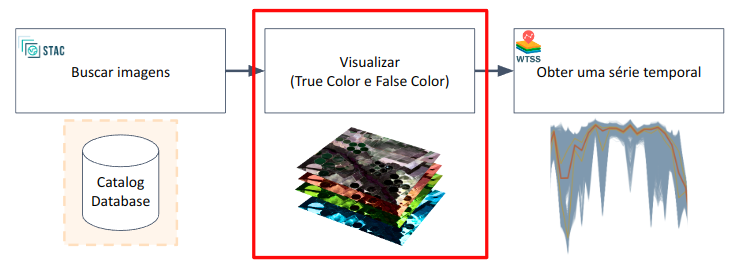

Para recuperar a matrix de pixels da imagem indicada no atributo `href` do *asset* será utilizada a biblioteca `rasterio`.

In [ ]:
# !pip install rasterio

Vamos fazer a visualização desse dado.

OBS: Pode demorar um pouco a depender da conexão com a internet, pois estamos obtendo uma banda inteira da imagem.

In [ ]:
import rasterio
from matplotlib import pyplot as plt

with rasterio.open(B04.href) as src:
    band = src.read(1)

plt.imshow(band, cmap='gray')
plt.show()

## Recuperando parte de uma imagem correspondente a uma região
<hr style="border:1px solid #0077b9;">

Vamos definir algumas funções auxiliares para nos ajudar nesse Jupyter Notebook.

- `normalize`: Normaliza, para visualização, o valor de imagens.

- `read_img`: Lê uma imagem usando Window.

In [ ]:
import numpy as np
from rasterio.windows import from_bounds, Window

from rasterio.warp import transform_bounds
from rasterio.windows import transform as window_transform

def read_img(uri: str, bbox: tuple = None, bbox_crs: str = "EPSG:4326", masked: bool = True):
    """Read raster window as numpy.ma.masked_array."""
    with rasterio.open(uri) as src:
        if bbox is not None:
            # reprojeta o bbox para o CRS do raster
            projected_bbox = transform_bounds(bbox_crs, src.crs, *bbox)
            window = from_bounds(*projected_bbox, transform=src.transform)
            data = src.read(window=window, masked=masked)
            new_transform = rasterio.windows.transform(window, src.transform)

            profile = src.profile.copy()
            profile.update({
                "height": window.height,
                "width": window.width,
                "transform": new_transform
            })
        else:
            data = src.read(masked=masked)
            profile = src.profile

    return data, profile

def normalize_and_adjust_brightness(array, brightness_factor=1):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    normalized = (array - array_min) / (array_max - array_min)
    brightened = np.clip(normalized * brightness_factor, 0.0, 1.0)
    return brightened

Neste exemplo, vamos visualizar a imagem do primeiro *asset* usando cor verdadeira e falsa cor.

Podemos ver o nome e url de cada asset desse item:

In [ ]:
assets = items[0].assets
assets

Vamos armazenar a url dos assets das bandas azul, verde, vermelho e infra-vermelho próximo.

In [ ]:
blue_asset = assets['B02']
green_asset = assets['B03']
red_asset = assets['B04']
nir_asset = assets['B08']

blue_asset.href

Como vamos abrir uma imagem que tem uma projeção customizada, vamos abrir os metadados de um primeiro asset e ler o CRS dele. Para assim termos um transformador de projeção.

Agora podemos usar o *Window* para abrir somente um pedaço da imagem

In [ ]:
b02_image, profile = read_img(items[-1].assets['B02'].href, bbox)
b03_image, _ = read_img(items[-1].assets['B03'].href, bbox)
b04_image, _ = read_img(items[-1].assets['B04'].href, bbox)
b08_image, _ = read_img(items[-1].assets['B08'].href, bbox)

In [ ]:
b03_image

Assim podemos visualizar as 4 imagens carregadas:

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4))
ax1.imshow(b02_image[0], cmap='gray')
ax1.set_title("Banda 2 (Azul)")
ax2.imshow(b03_image[0], cmap='gray')
ax2.set_title("Banda 3 (Verde)")
ax3.imshow(b04_image[0], cmap='gray')
ax3.set_title("Banda 4 (Vermelho)")
ax4.imshow(b08_image[0], cmap='gray')
ax4.set_title("Banda 8 (Infra-vermelho Próximo)")

Podemos fazer um stack e visualizar a *Cor Verdadeira*:

In [ ]:
rgb_normalized_stack = np.dstack(
    (normalize_and_adjust_brightness(b04_image[0], 3), 
     normalize_and_adjust_brightness(b03_image[0], 3), 
     normalize_and_adjust_brightness(b02_image[0], 3)))
plt.imshow(rgb_normalized_stack)

Bem como compor uma *Falsa Cor*

In [ ]:
rgb_normalized_stack = np.dstack(
    (normalize_and_adjust_brightness(b08_image[0], 1.5), 
     normalize_and_adjust_brightness(b04_image[0], 1.5), 
     normalize_and_adjust_brightness(b03_image[0], 1.5)))
plt.imshow(rgb_normalized_stack)

Podemos inclusive fazer a visualização dessa imagem no nosso mapa Folium.

OBS: como nosso dado não encontra-se no EPSG 4326, precisaremos reprojetar e usar os limites do Window utilizado.

Abrir outra data

In [ ]:
items[0]

In [ ]:
b03_image, _ = read_img(items[0].assets['B03'].href, bbox)
b04_image, _ = read_img(items[0].assets['B04'].href, bbox)
b08_image, _ = read_img(items[0].assets['B08'].href, bbox)

rgb_normalized_stack = np.dstack((
    normalize_and_adjust_brightness(b08_image[0], 1.5), 
    normalize_and_adjust_brightness(b04_image[0], 1.5), 
    normalize_and_adjust_brightness(b03_image[0], 1.5)))
plt.imshow(rgb_normalized_stack)

Comparar ambas

In [ ]:
print(items[-1].id)
print(items[0].id)

In [ ]:
camada_cena_1 = TileLayer(
    name=items[-1].id,
    url="https://data.inpe.br/bdc/tms/tiles/WebMercatorQuad/{z}/{x}/{y}" + f"?url={items[-1].assets['TCI'].href}"
)

camada_cena_2 = TileLayer(
    name=items[0].id,
    url="https://data.inpe.br/bdc/tms/tiles/WebMercatorQuad/{z}/{x}/{y}" + f"?url={items[0].assets['TCI'].href}"
)

mapa_comp = Map(zoom=13, scroll_wheel_zoom=True, layout=Layout(width='80%', height='500px'), center=(centroide.y, centroide.x))

mapa_comp.add(camada_poly)

control = SplitMapControl(left_layer=camada_cena_1, right_layer=camada_cena_2)

mapa_comp.add(control)

mapa_comp.add(LayersControl(position='topright'))
mapa_comp.add(FullScreenControl())
mapa_comp.add(ScaleControl(position='bottomleft'))

display(mapa_comp)

# 4. Visualizar área de queimada

---


In [ ]:
s2 = catalogo.get_collection("S2_L2A-1")

bbox = (-49.1456,-20.7272,-48.8881,-20.5765)

item_search = catalogo.search(
    collections=[s2],
    bbox=bbox,
    datetime='2024-08-21/2024-08-24',
    limit = 100
)

item_search.matched()

In [ ]:
items = item_search.item_collection()
item = items[0]

b02_image, _ = read_img(item.assets['B02'].href, bbox)
b03_image, _ = read_img(item.assets['B03'].href, bbox)
b04_image, _ = read_img(item.assets['B04'].href, bbox)

rgb_normalized_stack = np.dstack((
    normalize_and_adjust_brightness(b04_image[0], 2.5), 
    normalize_and_adjust_brightness(b03_image[0], 2.5), 
    normalize_and_adjust_brightness(b02_image[0], 2.5)))
plt.imshow(rgb_normalized_stack)

In [ ]:
camada_cena_1 = TileLayer(
    name=items[-1].id,
    url="https://data.inpe.br/bdc/tms/tiles/WebMercatorQuad/{z}/{x}/{y}" + f"?url={items[-1].assets['TCI'].href}"
)

camada_cena_2 = TileLayer(
    name=items[0].id,
    url="https://data.inpe.br/bdc/tms/tiles/WebMercatorQuad/{z}/{x}/{y}" + f"?url={items[0].assets['TCI'].href}"
)

mapa_comp = Map(zoom=13, scroll_wheel_zoom=True, layout=Layout(width='80%', height='500px'), center=(-20.644671936506803, -49.04365539550782))

mapa_comp.add(camada_poly)

control = SplitMapControl(left_layer=camada_cena_1, right_layer=camada_cena_2)

mapa_comp.add(control)

mapa_comp.add(LayersControl(position='topright'))
mapa_comp.add(FullScreenControl())
mapa_comp.add(ScaleControl(position='bottomleft'))

display(mapa_comp)

# 3. Obter uma série temporal

---


Agora vamos obter e visualizar uma série temporal:

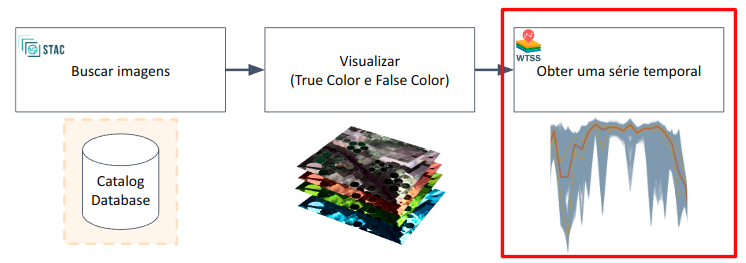

## <span style="color:#336699">Introdução ao Web Times Series Service (WTSS)<hr style="border:1px solid #0077b9;">

O **W**eb **T**ime **S**eries **S**ervice ou **WTSS** é um serviço web voltado para extração de séries temporais a partir de imagens de sensoriamento remoto organizadas na forma de cubos de dados. Dada uma localização ou região do espaço geográfico e um intervalo de tempo, a API deste serviço permite que os clientes requisitem as séries temporais para os produtos de dados do [Brazil Data Cube](https://data.inpe.br/bdc/web/) (Figura 1). Esse serviço pode ser utilizado a partir de um pacote construído para linguagem de programação [Python](https://github.com/brazil-data-cube/wtss.py), ou pode ser usado diretamente em interfaces gráficas com o usuário, por meio de [plugin do QGIS](https://github.com/brazil-data-cube/wtss-qgis) ou de componente gráfico de aplicações como o [Data Cube Explorer](https://data.inpe.br/bdc/explorer/) e [TerraCollect](https://data.inpe.br/bdc/terracollect/).

<center>
    <img src="https://geo-credito-rural.github.io/_images/overview.png" width="80%" />
    <br/>
    <b>Figura 1</b> - Visão geral do serviço WTSS.
</center>


<br/><br/>


O WTSS é baseado em três operações (Figura 2):
- `list_coverages`: Retorna a lista de produtos de dados, isto é, cubos de dados, disponíveis no serviço para consulta.

- `describe_coverage`: Retorna metadados básicos de um determinado cubo de dados.

- `time_series`: Consulta a lista de valores associadas a uma dada localização ou região do espaço geográfico e um intervalo de tempo.


**Nota:** O projeto original do WTSS utilizava a nomenclatura de *coverage* para se referir aos produtos de dados regulares no espaço e no tempo, como é o caso dos cubos de dados do Brazil Data Cube.


<br/><br/>


<center>    
    <img src="https://raw.githubusercontent.com/brazil-data-cube/code-gallery/master/img/wtss/wtss-operations.png?raw=true" align="center" width="768"/>
    <br/>
    <b>Figura 2</b> - Operações do Serviço WTSS.
    <br/>
    <b>Fonte</b>: Galeria de Código do Brazil Data Cube.
</center>


<br/><br/>


O pacote para a linguagem Python fornece abstrações próprias para utilização dessas operações.

## Cliente WTSS no Python
<hr style="border:1px solid #0077b9;">

<br/>

Para demonstrar o acesso aos produtos de dados do Brazil Data Cube, iremos utilizar uma bibloteca de software livre para Python denominada [wtss.py](https://github.com/brazil-data-cube/wtss.py) (`wtss`).

Para instalar essa biblioteca no ambiente Jupyter, pode ser utilizado o seguinte comando `pip install`:

In [ ]:
# !pip install wtss==2.0.0a3

Uma vez instalada a biblioteca `wtss`, podemos carregar suas funcionalidades através do comando `import`, como mostrado abaixo:

In [ ]:
import wtss

Em geral, uma biblioteca do ecossistema Python possui uma constante especial para informar a versão da biblioteca carregada. Abaixo, apresentamos a versão carregada  da biblioteca `wtss`:

In [ ]:
wtss.__version__

<img src="https://raw.githubusercontent.com/brazil-data-cube/code-gallery/master/img/wtss/list-coverages.png?raw=true" align="right" width="220"/>

## Verificando os Produtos de Dados Disponíveis no Serviço
<hr style="border:1px solid #0077b9;">

<br/><br/>

O endereço do serviço WTSS do BDC é https://data.inpe.br/bdc/wtss/v4/. Para descobrir os cubos de dados disponíveis para acesso nesse serviço,
é possível utilizar a classe `WTSS` do pacote `wtss`. Ao criar um objeto dessa classe, devemos informar a URL do serviço:

In [ ]:
servico = wtss.WTSS('https://data.inpe.br/bdc/wtss/v4/')

O WTSS utiliza a terminologia de **coverages** para se referir aos cubos de dados do Brazil Data Cube. A propriedade `coverages` retorna uma lista com os identificadores dos cubos de dados, isto é, das *coverages*, que podem ser consultadas pelo serviço:

In [ ]:
servico.coverages

Repare que os identificadores retornados pela propriedade `coverages` são os mesmos usados no catálogo STAC. Seus significados podem ser consultados no [Data Cube Explorer](https://data.inpe.br/bdc/explorer/), ou no [STAC Browser](https://data.inpe.br/stac/browser/) ou diretamente no [serviço STAC](https://data.inpe.br/bdc/stac/).

**Observação:** A documentação da classe `WTSS` pode ser vista [aqui](https://wtss.readthedocs.io/en/latest/class_wtss.html).

<img src="https://raw.githubusercontent.com/brazil-data-cube/code-gallery/master/img/wtss/describe-coverage.png?raw=true" align="right" width="220"/>

## Recuperando os Metadados de um Produto
<hr style="border:1px solid #0077b9;">

<br/>

Os identificadores retornados pela propriedade `coverages` podem ser utilizados nas operações seguintes do serviço, tanto para recuperação de metadados quanto da série temporal. O operador `[]` em um objeto `WTSS` permite acessar o metadado de um cubo de dados específico. Por exemplo, vamos considerar o cubo de dados Sentinel-2, com resolução espacial de 10 metros e composição temporal de 16 dias. Este produto é identificado na lista anterior como `S2-16D-2`. Vamos recuperar seus metadados no serviço WTSS:

In [ ]:
cubo_s2 = servico['S2-16D-2']
cubo_s2

Os metadados acima são um subconjunto dos metadados disponíveis no STAC e incluem:

- nome do cubo de dados

In [ ]:
cubo_s2.name

- descrição:

In [ ]:
cubo_s2.description

- Atributos (bandas ou índices espectrais):

In [ ]:
cubo_s2.attributes

- Retângulo envolvente da base de imagens do cubo de dados, representado como uma geometria do tipo `Polygon` da bibloteca `Shapely`.

In [ ]:
cubo_s2.spatial_extent

- Instantes de tempo das obervações disponíveis no cubo.

In [ ]:
timeline = cubo_s2.timeline

ultima_data_disponivel = timeline[0]
primeira_data_disponivel = timeline[-1]

print(f'Intervalo: [{primeira_data_disponivel}, {ultima_data_disponivel}]')

**Observação:** A documentação da classe `Coverage` pode ser vista [aqui](https://wtss.readthedocs.io/en/latest/class_coverage.html).

<img src="https://raw.githubusercontent.com/brazil-data-cube/code-gallery/master/img/wtss/time-series.png?raw=true" align="right" width="220"/>

## Recuperando a Série Temporal
<hr style="border:1px solid #0077b9;">

<br/><br/>

O método `ts` de um objeto `Coverage` permite recuperar a série temporal para uma dada localização ou região e conjunto de atributos. Vamos considerar o `cubo_s2` obtido anteriormente e recuperar as séries temporais para os atributos `NDVI` e `B08` (banda do infravermelho próximo ou NIR) na localização de latitude `-12.32800` e longitude `-45.90710` entre 01 de Janeiro de 2022 e 31 de Dezembro de 2023:

In [ ]:
lon, lat = -49.04517889022828, -20.62702079798649

In [ ]:
ts_search = cubo_s2.ts(attributes=['NDVI'],
                       latitude=lat, longitude=lon,
                       start_date='2019-01-01', end_date='2025-05-26')
ts_search

A propriedade `ts` permite recuperar um objeto representando as séries temporais:

In [ ]:
ts = ts_search.ts
ts

O objeto retornado `ts_search` (`TimeSeriesSearch`) possui métodos para recuperação da série temporal e para sua visualização:

In [ ]:
ts_search.plot()

O eixo do tempo, com os valores de datas, pode ser acessado com a propriedade `timeline`:

In [ ]:
ts.timeline

Os nomes dos atributos recuperados nas séries pode ser acessados pela propriedade `attributes`:

In [ ]:
ts.attributes

E os valores da série para cada atributo podem ser recuperados pelo método `values`:

In [ ]:
ts.values('NDVI')[0]

A Busca pode ser feita buscando varias bandas, no exemplo abaixo faremos a mesma busca, mas também obteremos a máscara de nuvens (banda SCL):

In [ ]:
ts_search = cubo_s2.ts(attributes=['NDVI', 'SCL'],
                       latitude=lat, longitude=lon,
                       start_date='2018-01-01', end_date='2025-05-26')
ts = ts_search.ts

In [ ]:
plt.figure(dpi = 120)

serie = ts.values('NDVI')[0]
cloud_mask_serie = ts.values('SCL')[0]
timeline = ts.timeline

plt.plot(serie, color='blue', label = 'NDVI')

scl_colors = {
    '0': 'black',  #Nodata
    '1': 'red',    #Saturated or defective
    '2': 'gray',   #Dark area pixels
    '3': 'brown',  #Cloud Shadow
    '4': 'green',  #Vegetation
    '5': 'yellow', #Not Vegetated
    '6': 'blue',   #Water
    '7': 'red',    #Unclassified
    '8': 'white',  #Cloud Medium Probability
    '9': 'white',  #Cloud High Probability
    '10': 'cyan',  #Thin Cirrus
    '11': 'pink'   #Snow
}

for idx, scl_value in enumerate(cloud_mask_serie):
    color = scl_colors[str(int(scl_value))]
    plt.scatter(idx, serie[idx], edgecolor='black', color=color, s=50, zorder=5)

step = 8

labels = [timeline[i] if i % step == 0 else '' for i in range(len(timeline))]

plt.xticks(ticks=range(len(timeline)),
           labels=labels,
           rotation=45, ha='right')

plt.title('NDVI com rótulos SCL')
plt.legend()
plt.show()

In [ ]:
mask = np.isin(np.array(cloud_mask_serie), [4, 5, 6])
scl_serie = np.array(cloud_mask_serie)[mask]
filtered_serie = np.array(serie)[mask]
timeline_serie = np.array(timeline)[mask]

In [ ]:
plt.plot(filtered_serie, color='blue', label = 'NDVI')

for idx, scl_value in enumerate(scl_serie):
    color = scl_colors[str(int(scl_value))]
    plt.scatter(idx, filtered_serie[idx], edgecolor='black', color=color, s=50, zorder=5)

step = 8
labels = [timeline_serie[i] if i % step == 0 else '' for i in range(len(timeline_serie))]

plt.xticks(ticks=range(len(timeline_serie)),
           labels=labels,
           rotation=45, ha='right')

plt.title('NDVI mascarado com rótulos SCL')
plt.legend()
plt.show()

## Recuperando a Série Temporal de uma área
<hr style="border:1px solid #0077b9;">

<br/><br/>

Finalmente, vamos recuperar as séries temporais da area apresentada no mapa acima, por meio do client Python do serviço WTSS:

In [ ]:
from shapely.geometry import box

geom = box(-49.0461,-20.6277,-49.0445,-20.6263)

ts_search = cubo_s2.ts(attributes=['NDVI', 'B08'],
                       geom=geom,
                       start_date='2019-01-01', end_date='2024-12-31')
ts_search

In [ ]:
ts_search.plot()

Podemos ter mais informações sobre as séries acessando o atributo `ts`:

In [ ]:
ts = ts_search.ts
ts

Para acessar todos os valores de NDVI por exemplo você pode acessar com:

In [ ]:
ts.values('NDVI') # Todas as séries

ts.values('NDVI')[0] # Primeira série

ts.values('NDVI')[1] # Segunda série